In [1]:
import metview as mv
import rioxarray 
import xarray
from shapely.geometry import (Polygon, mapping)
import geopandas

mv.setoutput('jupyter', output_font_scale=1.5, plot_widget=False)

#### Polígonos del parque Cerro Saroche

In [2]:
park_poligono = geopandas.read_file('./cerro_saroche/poligono_cerro_saroche/cerro_saroche.shp')
parque_rectangulo = geopandas.read_file('./cerro_saroche/poligono_cerro_saroche/rectangulo_cerro_saroche.shp')

#### Precipitación

* Transformación de la precipitación a NETCDF.

In [3]:
precipitacion_rds = rioxarray.open_rasterio('./cerro_saroche/cdsapi/total_precipitation.grib',
                              masked=True
                              )\
                              .squeeze()
# proyeccion
precipitacion_rds.rio.crs

ERROR: Ran out of file reading SECT0


CRS.from_wkt('GEOGCS["Coordinate System imported from GRIB file",DATUM["unnamed",SPHEROID["Sphere",6367470,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]')

In [4]:
import pandas as pd
from datetime import datetime
import numpy as np

# Tranformando band a datetime 
date_range = pd.date_range(start='1970-01-01',
                          freq='M',
                          periods = precipitacion_rds.band.values.shape[0]
                          )

date_range = np.array(list(map(lambda x: datetime.strptime( str(x)[:8]+'01','%Y-%m-%d').toordinal(), date_range )))

In [5]:
# creando netcdf
ds_precipitacion = xarray.Dataset({
        'precipitacion_mm' : xarray.DataArray(
                    data = 1000*precipitacion_rds.data,
                    dims = ['time','y','x'],
                    coords = {'time':date_range,'y': precipitacion_rds['y'].data, 'x': precipitacion_rds['x'].data},
                    attrs = precipitacion_rds.attrs
                    )
          },
    attrs = {'GRIB_COMMENT': 'Total precipitation [mm]',
            'GRIB_ELEMENT': 'TP',
            'GRIB_FORECAST_SECONDS': 86400,
            'GRIB_REF_TIME': 0,
            'GRIB_SHORT_NAME': '0-SFC',
            'GRIB_UNIT': '[mm]',
            'GRIB_VALID_TIME': 86400,
            'scale_factor': 1.0,
            'add_offset': 0.0,
            'long_name': '0[-] SFC (Ground or water surface)'}
    )

# agregando crs
ds_precipitacion = ds_precipitacion.rio.set_crs(precipitacion_rds.rio.crs)
ds_precipitacion = ds_precipitacion.rio.write_crs(precipitacion_rds.rio.crs)

In [6]:
park_poligono = park_poligono.to_crs(precipitacion_rds.rio.crs)
parque_rectangulo = parque_rectangulo.to_crs(precipitacion_rds.rio.crs)

# rectangulo del parque
precipitacion_rectangulo = ds_precipitacion.rio.clip(parque_rectangulo.geometry.apply(mapping),
                                                    all_touched=False,
                                                    crs=precipitacion_rds.rio.crs,
                                                    from_disk=True)

In [7]:
precipitacion_rectangulo.to_netcdf('./cerro_saroche/cdsapi/precipitacion_regrilla.nc')

In [8]:
date_srt = datetime.fromordinal(
                precipitacion_rectangulo.time.values[0])\
                  .strftime('%Y-%m-%d')

date_srt

'1970-01-01'

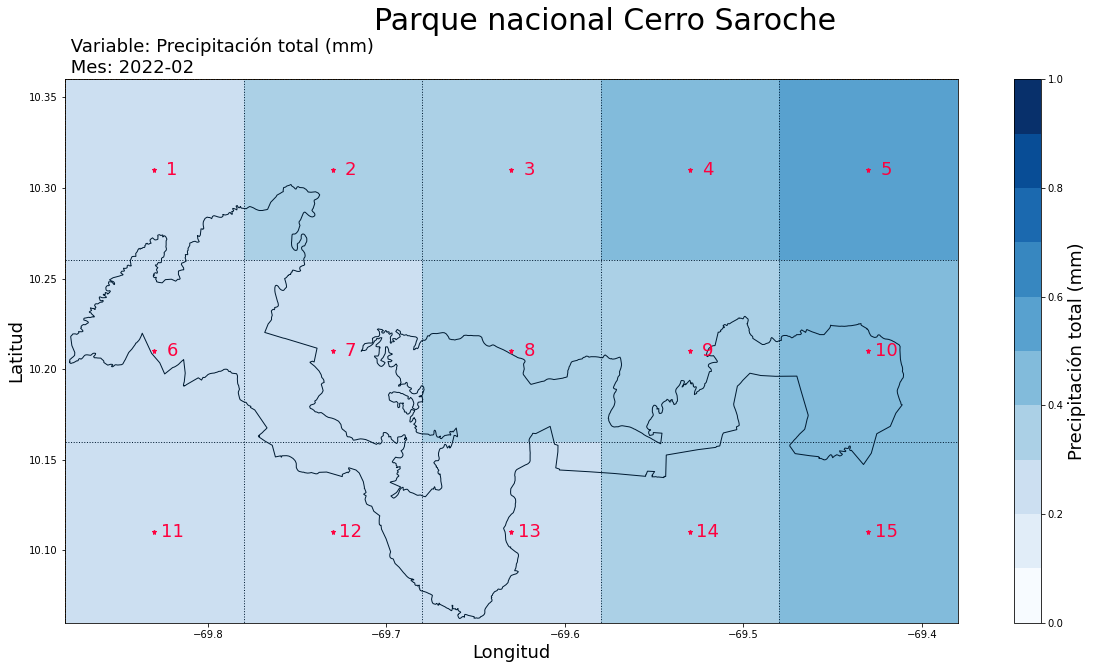

In [9]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np

# centros
x = np.arange(-70.13,-69.13,0.1)
y = np.arange(9.81,10.51,0.1)

# grilla
x_grid = x + 0.05
y_grid  = y + 0.05


# plot
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1)


# raster
time_lebel = 625
levels=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
graf = precipitacion_rectangulo.isel(time=time_lebel)\
                               .precipitacion_mm\
                               .plot(cmap='Blues',
                                    levels=levels
                                    )
graf.colorbar.set_label('Precipitación total (mm)',fontsize=18)
ax.add_collection(graf)

# poligonos
x1,y1 = park_poligono.geometry.iloc[0].exterior.xy
ax.plot(x1,y1, color='#001B32', linewidth=1)

x2,y2 = parque_rectangulo.geometry.iloc[0].exterior.xy
ax.plot(x2,y2, color='#BF6300', linewidth=1,linestyle='dashed')

# centroides
annotate = 1
annotate_list = 15*[0]+[11,6,1]+3*[0]+[12,7,2]+3*[0]+[13,8,3]+3*[0]+[14,9,4]+3*[0]+[15,10,5]+30*[0]
for i in list(range(1, len(x) )):
  for j in list(range(1, len(y) )):
    ax.plot(x[i],y[j],color = '#FF003E', marker='*', label=i, markersize=5)
    ax.annotate(str(annotate_list[annotate]),  xy=(x[i]+0.01,y[j]), color='#FF003E',
            fontsize=18, #weight='',
            horizontalalignment='center',
            verticalalignment='center')
    annotate+=1

# grilla
color_grid = '#001B32'
for i in list(range( len(x_grid) )):
  ax.vlines(x = x_grid[i],ymin=min(y_grid),ymax=max(y_grid),
            colors = color_grid,
            linestyles='dotted',
            linewidth=1,
            label = 'vline_multiple - full height')

for i in list(range( len(y_grid) )):
  ax.hlines(y = y_grid[i],xmin=min(x_grid),xmax=max(x_grid),
            colors = color_grid,
            linestyles='dotted',
            linewidth=1,
            label = 'vline_multiple - full height')


# dia
date_srt = datetime.fromordinal(
                precipitacion_rectangulo.time.values[time_lebel])\
                  .strftime('%Y-%m')

# titulos
plt.title(f" Variable: Precipitación total (mm)\n Mes: {date_srt}",fontsize=18,loc='left')
plt.title(f"",fontsize=30,loc='center')
plt.suptitle(f"Parque nacional Cerro Saroche\n",fontsize=30)
plt.xlabel("Longitud",loc='center',fontsize=18)
plt.ylabel("Latitud",loc='center',fontsize=18)

plt.savefig('./cerro_saroche/figuras/grilla_precipitacion.png')

plt.show()

#### Elevación

In [10]:
elevacion_rds = rioxarray.open_rasterio('./cerro_saroche/SRTMGL3/elevacion.nc',
                              masked=True
                              )\
                              .squeeze()\
                              .to_dataset()

elevacion = elevacion_rds.rio.reproject(precipitacion_rds.rio.crs)

In [11]:
# elevacion del parque
elevacion_park = elevacion.rio.clip(parque_rectangulo.geometry.apply(mapping),
                    all_touched=False,
                    from_disk=True)\
                    .squeeze()\
                    .chunk("auto")

elevacion_park

<xarray.Dataset>
Dimensions:      (y: 360, x: 600)
Coordinates:
  * y            (y) float64 10.36 10.36 10.36 10.36 ... 10.06 10.06 10.06 10.06
  * x            (x) float64 -69.88 -69.88 -69.88 ... -69.38 -69.38 -69.38
    band         int64 1
    spatial_ref  int64 0
Data variables:
    elevacion    (y, x) float32 dask.array<chunksize=(360, 600), meta=np.ndarray>

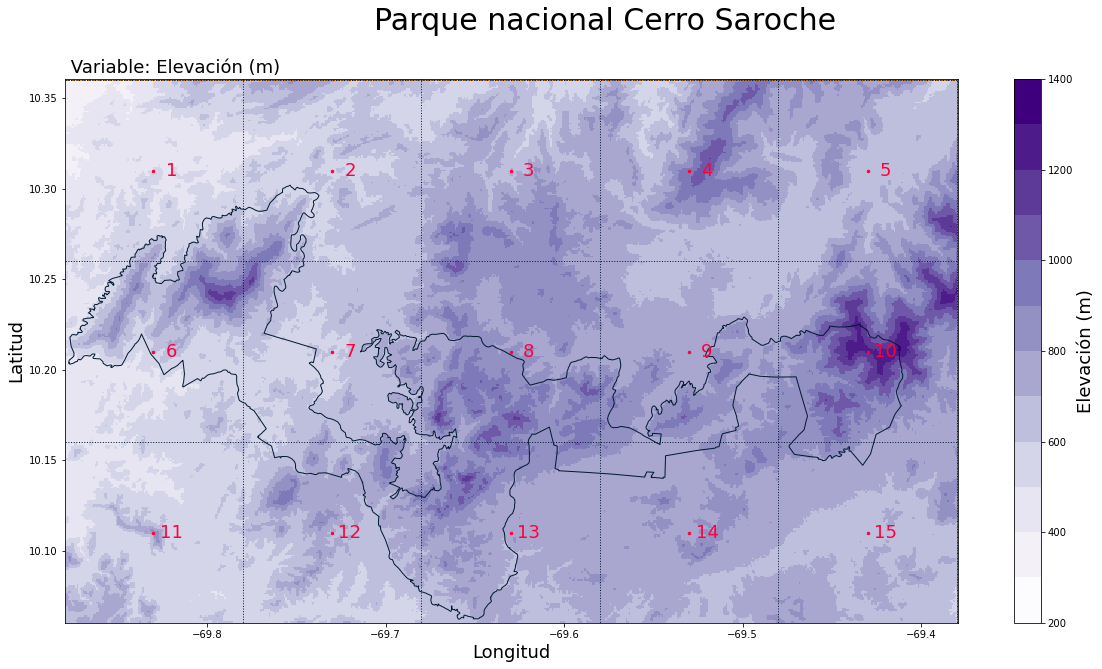

In [12]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np

# centros
x = np.arange(-70.13,-69.13,0.1)
y = np.arange(9.81,10.51,0.1)

# grilla
x_grid = x + 0.05
y_grid  = y + 0.05

# plot
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1)

# raster
levels=[200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400]
graf = elevacion_park.elevacion.plot(cmap='Purples',levels=levels)
graf.colorbar.set_label('Elevación (m)',fontsize=18)
ax.add_collection(graf)

# poligonos
x1,y1 = park_poligono.geometry.iloc[0].exterior.xy
ax.plot(x1,y1, color='#001B32', linewidth=1)

x2,y2 = parque_rectangulo.geometry.iloc[0].exterior.xy
ax.plot(x2,y2, color='#BF6300', linewidth=1,linestyle='dashed')


# centroides
annotate = 1
annotate_list = 15*[0]+[11,6,1]+3*[0]+[12,7,2]+3*[0]+[13,8,3]+3*[0]+[14,9,4]+3*[0]+[15,10,5]+30*[0]
for i in list(range(1, len(x) )):
  for j in list(range(1, len(y) )):
    ax.plot(x[i],y[j],color = '#FF003E', marker='.', label=i, markersize=5)
    ax.annotate(str(annotate_list[annotate]),  xy=(x[i]+0.01,y[j]), color='#FF003E',
        fontsize=18, #weight='',
        horizontalalignment='center',
        verticalalignment='center')
    annotate+=1

# grilla
color_grid = '#001B32'
for i in list(range( len(x_grid) )):
  ax.vlines(x = x_grid[i],ymin=min(y_grid),ymax=max(y_grid),
            colors = color_grid,
            linestyles='dotted',
            linewidth=1,
            label = 'vline_multiple - full height')

for i in list(range( len(y_grid) )):
  ax.hlines(y = y_grid[i],xmin=min(x_grid),xmax=max(x_grid),
            colors = color_grid,
            linestyles='dotted',
            linewidth=1,
            label = 'vline_multiple - full height')

# titulos
plt.title(f" Variable: Elevación (m)",fontsize=18,loc='left')
plt.title(f"",fontsize=30,loc='center')
plt.suptitle(f"Parque nacional Cerro Saroche\n",fontsize=30)
plt.xlabel("Longitud",loc='center',fontsize=18)
plt.ylabel("Latitud",loc='center',fontsize=18)


plt.savefig('./cerro_saroche/figuras/grilla_elevacion.png')

plt.show()

#### Regrillado elevación

In [13]:
import warnings
warnings.filterwarnings("ignore")


rds = precipitacion_rds
rds_trgrilla = elevacion
band = 'elevacion'
x_name='x'
y_name='y'


y = rds[y_name].to_numpy()
x = rds[x_name].to_numpy()

# grilla
y_grid = y + 0.05
x_grid = x + 0.05

list_grid = []
for i, i_ in enumerate(y_grid[:-1]):
  list_i = []
  for j, j_ in enumerate(x_grid[:-1]):
    poly = Polygon( [(x_grid[j],y_grid[i,]),(x_grid[j+1],y_grid[i]),(x_grid[j+1],y_grid[i+1]),(x_grid[j],y_grid[i+1]),(x_grid[j],y_grid[i,])] )
    poligono = geopandas.GeoSeries(poly, crs = rds.rio.crs) 
    region = rds_trgrilla.rio.clip(poligono.geometry.apply(mapping),
                          all_touched=False,
                          from_disk=True)
    list_i.append({ 'x':j_,
                    'y':i_,
                    'mean': float(region[band].mean()),
                    'median': float(region[band].median()),
                    'max': float(region[band].max()),
                    'centroide': (float(poligono.centroid.x), float(poligono.centroid.y)),
                    'poligono':poligono,
                    'region':region
                    }) 
  
  list_grid.append(list_i)

In [14]:
centroide_x = list(map(lambda x: [y.get('centroide')[0] for y in x] , list_grid))[0]
centroide_y = list(map(lambda x: [y.get('centroide')[1] for y in x][0] , list_grid))

media = list(map(lambda x: [y.get('mean') for y in x] , list_grid))
mediana = list(map(lambda x: [y.get('median') for y in x] , list_grid))
maximo = list(map(lambda x: [y.get('max') for y in x] , list_grid))

In [15]:
fieldset = [{
              "gridType": "regular_ll",
              "Nx": len(centroide_x),
              "Ny": len(centroide_y),
              "distinctLatitudes": centroide_y,
              "distinctLongitudes": centroide_x,
              "paramId": 1,
              "shortName": f"{band}_media",
              "values": media,
              "dataDate": 20211216,
              "dataTime": 1200
              },
              {
              "gridType": "regular_ll",
              "Nx": len(centroide_x),
              "Ny": len(centroide_y),
              "distinctLatitudes": centroide_y,
              "distinctLongitudes": centroide_x,
              "paramId": 2,
              "shortName": f"{band}_mediana",
              "values": mediana,
              "dataDate": 20211216,
              "dataTime": 1200
              },
              {
              "gridType": "regular_ll",
              "Nx": len(centroide_x),
              "Ny": len(centroide_y),
              "distinctLatitudes": centroide_y,
              "distinctLongitudes": centroide_x,
              "paramId": 3,
              "shortName": f"{band}_maxima",
              "values": maximo,
              "dataDate": 20211216,
              "dataTime": 1200
              }
              ]

ds = xarray.open_dataset(fieldset, engine="cfgrib")
ds = ds.rio.write_crs(precipitacion_rds.rio.crs)

#ds.to_netcdf('./cerro_saroche/SRTMGL3/elevacion_regrilla.nc')

In [16]:
# elevacion del parque
ds_rect = ds.rio.clip(parque_rectangulo.geometry.apply(mapping),
                    all_touched=False,
                    from_disk=True)

ds_rect.to_netcdf('./cerro_saroche/SRTMGL3/elevacion_regrilla.nc')

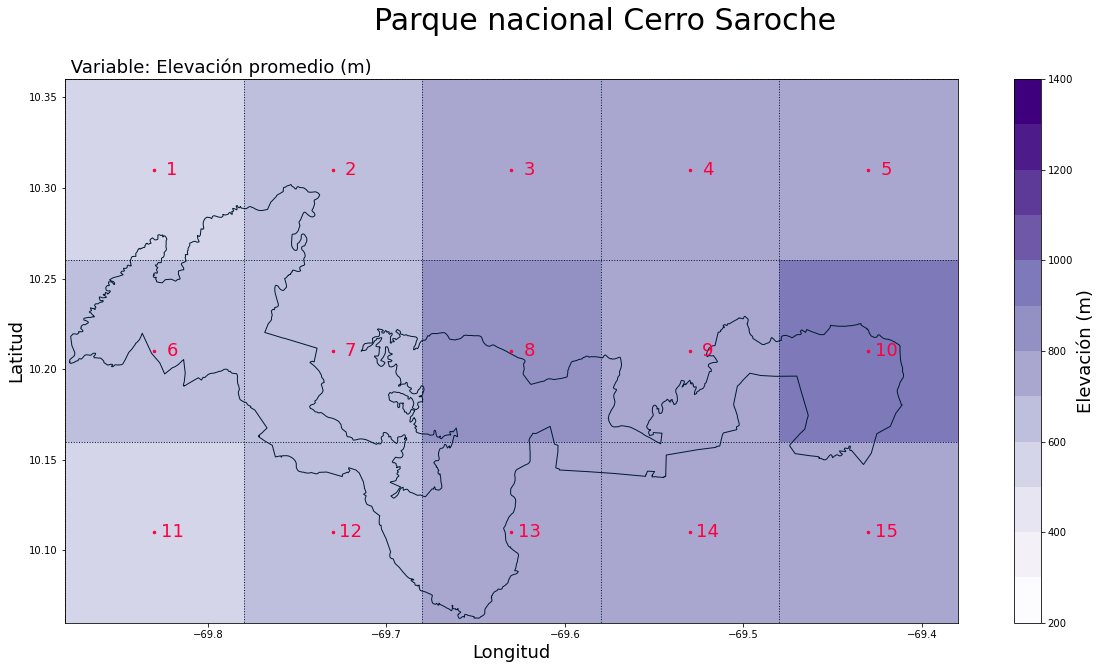

In [17]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np

# centros
x = np.arange(-70.13,-69.13,0.1)
y = np.arange(9.81,10.51,0.1)

# grilla
x_grid = x + 0.05
y_grid  = y + 0.05

# plot
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1)

# raster
# raster
levels=[200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400]
graf = ds_rect.elevacion_media.plot(cmap='Purples',levels=levels)
graf.colorbar.set_label('Elevación (m)',fontsize=18)
ax.add_collection(graf)

# poligonos
x1,y1 = park_poligono.geometry.iloc[0].exterior.xy
ax.plot(x1,y1, color='#001B32', linewidth=1)

x2,y2 = parque_rectangulo.geometry.iloc[0].exterior.xy
ax.plot(x2,y2, color='#BF6300', linewidth=1,linestyle='dashed')

# centroides
annotate = 1
annotate_list = 15*[0]+[11,6,1]+3*[0]+[12,7,2]+3*[0]+[13,8,3]+3*[0]+[14,9,4]+3*[0]+[15,10,5]+30*[0]
for i in list(range(1, len(x) )):
  for j in list(range(1, len(y) )):
    ax.plot(x[i],y[j],color = '#FF003E', marker='.', label=i, markersize=5)
    ax.annotate(str(annotate_list[annotate]),  xy=(x[i]+0.01,y[j]), color='#FF003E',
        fontsize=18, #weight='',
        horizontalalignment='center',
        verticalalignment='center')
    annotate+=1

# grilla
color_grid = '#001B32'
for i in list(range( len(x_grid) )):
  ax.vlines(x = x_grid[i],ymin=min(y_grid),ymax=max(y_grid),
            colors = color_grid,
            linestyles='dotted',
            linewidth=1,
            label = 'vline_multiple - full height')

for i in list(range( len(y_grid) )):
  ax.hlines(y = y_grid[i],xmin=min(x_grid),xmax=max(x_grid),
            colors = color_grid,
            linestyles='dotted',
            linewidth=1,
            label = 'vline_multiple - full height')


# titulos
plt.title(f" Variable: Elevación promedio (m)",fontsize=18,loc='left')
plt.title(f"",fontsize=30,loc='center')
plt.suptitle(f"Parque nacional Cerro Saroche\n",fontsize=30)
plt.xlabel("Longitud",loc='center',fontsize=18)
plt.ylabel("Latitud",loc='center',fontsize=18)

plt.savefig('./cerro_saroche/figuras/regrillado_elevacion.png')

plt.show()

#### Vegetación

In [18]:
path_vegetacion = './cerro_saroche/MOD13Q1_V6/summary/summary.MOD13Q1V6.20120101.20220423.nc'
rds = rioxarray.open_rasterio(path_vegetacion,
                              masked=True
                              ).squeeze()

# cambiando proyeccion
rds_vegetacion = rds.rio.reproject(precipitacion_rds.rio.crs)

In [19]:
rds_vegetacion

<xarray.Dataset>
Dimensions:                  (x: 226, y: 105, time: 198)
Coordinates:
  * x                        (x) float64 -69.9 -69.9 -69.89 ... -69.38 -69.38
  * y                        (y) float64 10.3 10.3 10.3 ... 10.07 10.06 10.06
  * time                     (time) int64 734503 734519 734535 ... 738252 738268
    spatial_ref              int64 0
Data variables:
    250m 16 days NDVI        (time, y, x) float32 nan nan nan ... nan nan nan
    250m 16 days EVI         (time, y, x) float32 nan nan nan ... nan nan nan
    250m 16 days VI Quality  (time, y, x) float32 nan nan nan ... nan nan nan
    QA_EVI                   (time, y, x) float32 nan nan nan ... nan nan nan
    QA_NDVI                  (time, y, x) float32 nan nan nan ... nan nan nan
Attributes: (12/173)
    ALGORITHMPACKAGEACCEPTANCEDATE:      102004
    ALGORITHMPACKAGEMATURITYCODE:        Normal
    ALGORITHMPACKAGENAME:                MOD_PR13A1
    ALGORITHMPACKAGEVERSION:             6
    ASSOCIATEDINSTRUMENTSHORTNAME.1:     MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:       Terra
    ...                                  ...
    SOUTHBOUNDINGCOORDINATE:             0
    SPSOPARAMETERS:                      2749, 4334, 2749a, 4334a
    TileID:                              51010008
    VERSIONID:                           6
    VERTICALTILENUMBER:                  8
    WESTBOUNDINGCOORDINATE:              -81.23412894334

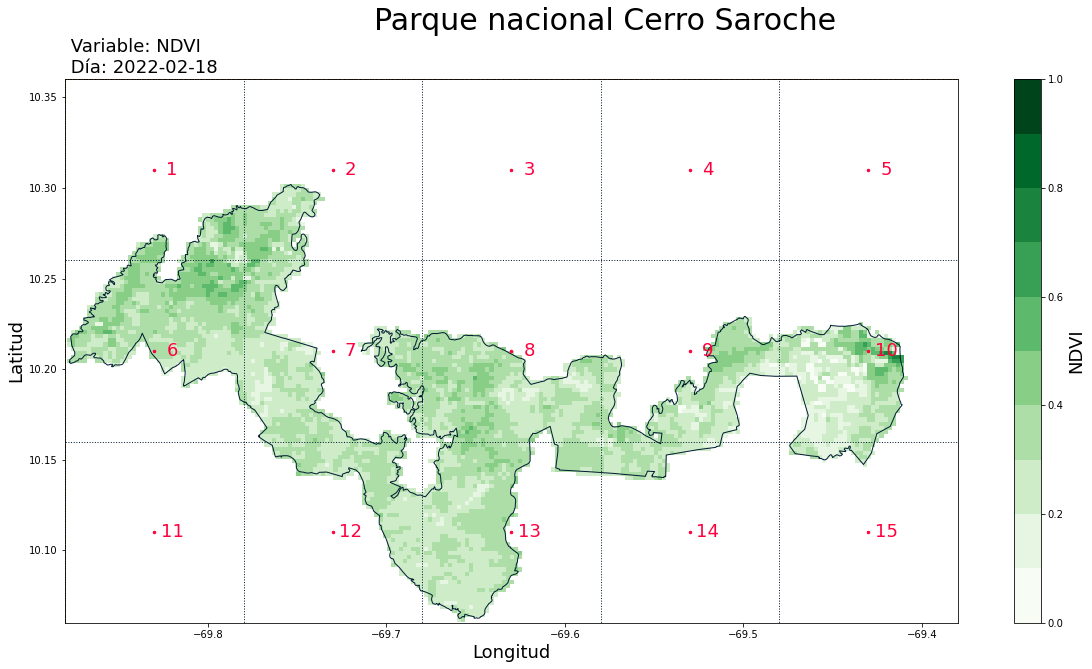

In [20]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np

# centros
x = np.arange(-70.13,-69.13,0.1)
y = np.arange(9.81,10.51,0.1)

# grilla
x_grid = x + 0.05
y_grid  = y + 0.05

# plot
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1)

# raster
time_lebel = 193
levels=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
graf = rds_vegetacion.isel(time=time_lebel).QA_NDVI.plot(cmap='Greens',levels=levels)
graf.colorbar.set_label('NDVI',fontsize=18)
ax.add_collection(graf)

# poligonos
x1,y1 = park_poligono.geometry.iloc[0].exterior.xy
ax.plot(x1,y1, color='#001B32', linewidth=1)

x2,y2 = parque_rectangulo.geometry.iloc[0].exterior.xy
ax.plot(x2,y2, color='#BF6300', linewidth=1,linestyle='dashed')


# centroides
annotate = 1
annotate_list = 15*[0]+[11,6,1]+3*[0]+[12,7,2]+3*[0]+[13,8,3]+3*[0]+[14,9,4]+3*[0]+[15,10,5]+30*[0]
for i in list(range(1, len(x) )):
  for j in list(range(1, len(y) )):
    ax.plot(x[i],y[j],color = '#FF003E', marker='.', label=i, markersize=5)
    ax.annotate(str(annotate_list[annotate]),  xy=(x[i]+0.01,y[j]), color='#FF003E',
        fontsize=18, #weight='',
        horizontalalignment='center',
        verticalalignment='center')
    annotate+=1

# grilla
color_grid = '#001B32'
for i in list(range( len(x_grid) )):
  ax.vlines(x = x_grid[i],ymin=min(y_grid),ymax=max(y_grid),
            colors = color_grid,
            linestyles='dotted',
            linewidth=1,
            label = 'vline_multiple - full height')

for i in list(range( len(y_grid) )):
  ax.hlines(y = y_grid[i],xmin=min(x_grid),xmax=max(x_grid),
            colors = color_grid,
            linestyles='dotted',
            linewidth=1,
            label = 'vline_multiple - full height')

# dia
date_srt = datetime.fromordinal(
                rds_vegetacion.time.values[time_lebel])\
                  .strftime('%Y-%m-%d')

# titulos
plt.title(f" Variable: NDVI\n Día: {date_srt}",fontsize=18,loc='left')
plt.title(f"",fontsize=30,loc='center')
plt.suptitle(f"Parque nacional Cerro Saroche\n",fontsize=30)
plt.xlabel("Longitud",loc='center',fontsize=18)
plt.ylabel("Latitud",loc='center',fontsize=18)
plt.xlim([-69.88, -69.38])
plt.ylim([10.06, 10.36])

plt.show()

#### Llevando ndvi a valores mensuales

In [21]:
time = list(map(lambda x: datetime.fromordinal(x).strftime('%Y-%m'),
                            rds_vegetacion.time.values.tolist()
                ))

time = list(map(lambda x: datetime.strptime(x+'-01','%Y-%m-%d').toordinal() ,time))

# creando netcdf
ds_ndvi = xarray.Dataset({
        'ndvi' : xarray.DataArray(
                    data = rds_vegetacion.QA_NDVI.data,
                    dims = ['time','y','x'],
                    coords = {'time':time,'y': rds_vegetacion['y'].data, 'x': rds_vegetacion['x'].data},
                    attrs = rds_vegetacion.attrs
                    )
          },
    attrs = rds_vegetacion.attrs
    )

# agregando ds_ndvi
ds_ndvi = ds_ndvi.rio.set_crs(precipitacion_rds.rio.crs)
ds_ndvi = ds_ndvi.rio.write_crs(precipitacion_rds.rio.crs)

In [22]:
# Agrupando los valores a mensuales
ds_ndvi_mes = ds_ndvi.groupby('time').mean('time')
ds_ndvi_mes

<xarray.Dataset>
Dimensions:      (y: 105, x: 226, time: 110)
Coordinates:
  * y            (y) float64 10.3 10.3 10.3 10.29 ... 10.07 10.07 10.06 10.06
  * x            (x) float64 -69.9 -69.9 -69.89 -69.89 ... -69.39 -69.38 -69.38
    spatial_ref  int64 0
  * time         (time) int64 734503 734534 734563 ... 738187 738215 738246
Data variables:
    ndvi         (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan

In [23]:
datetime.fromordinal(ds_ndvi_mes.time.values[0]).strftime('%Y-%m')

'2012-01'

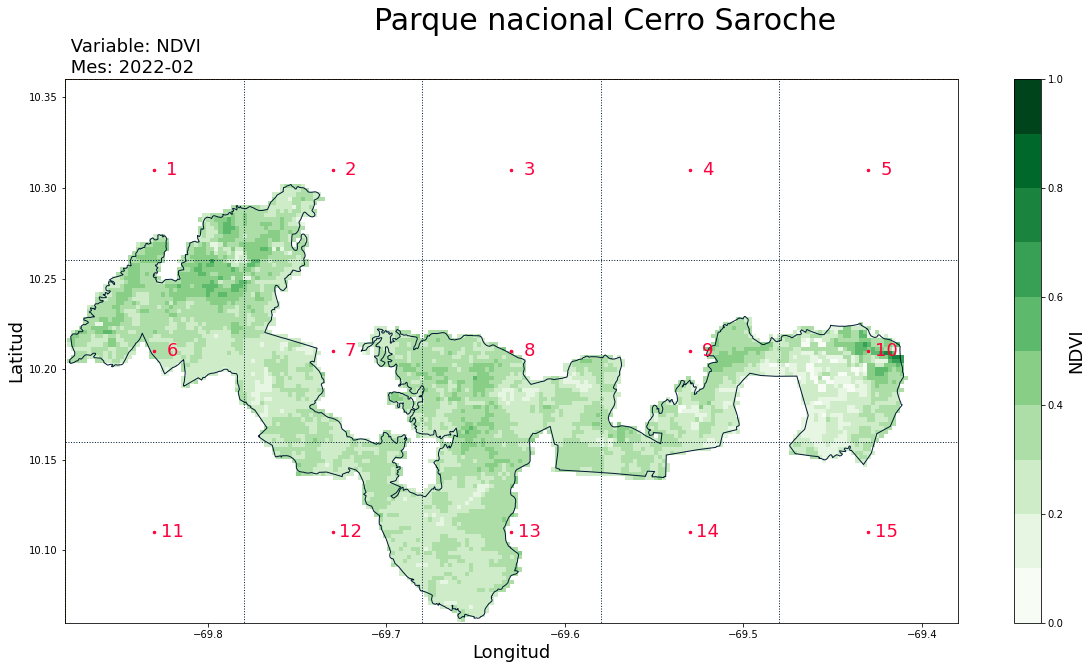

In [24]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np

# centros
x = np.arange(-70.13,-69.13,0.1)
y = np.arange(9.81,10.51,0.1)

# grilla
x_grid = x + 0.05
y_grid  = y + 0.05

# plot
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1)

# raster
time_lebel = 107
levels=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
graf = ds_ndvi_mes.isel(time=time_lebel).ndvi.plot(cmap='Greens',levels=levels)
graf.colorbar.set_label('NDVI',fontsize=18)
ax.add_collection(graf)

# poligonos
x1,y1 = park_poligono.geometry.iloc[0].exterior.xy
ax.plot(x1,y1, color='#001B32', linewidth=1)

x2,y2 = parque_rectangulo.geometry.iloc[0].exterior.xy
ax.plot(x2,y2, color='#BF6300', linewidth=1,linestyle='dashed')


# centroides
annotate = 1
annotate_list = 15*[0]+[11,6,1]+3*[0]+[12,7,2]+3*[0]+[13,8,3]+3*[0]+[14,9,4]+3*[0]+[15,10,5]+30*[0]
for i in list(range(1, len(x) )):
  for j in list(range(1, len(y) )):
    ax.plot(x[i],y[j],color = '#FF003E', marker='.', label=i, markersize=5)
    ax.annotate(str(annotate_list[annotate]),  xy=(x[i]+0.01,y[j]), color='#FF003E',
        fontsize=18, #weight='',
        horizontalalignment='center',
        verticalalignment='center')
    annotate+=1

# grilla
color_grid = '#001B32'
for i in list(range( len(x_grid) )):
  ax.vlines(x = x_grid[i],ymin=min(y_grid),ymax=max(y_grid),
            colors = color_grid,
            linestyles='dotted',
            linewidth=1,
            label = 'vline_multiple - full height')

for i in list(range( len(y_grid) )):
  ax.hlines(y = y_grid[i],xmin=min(x_grid),xmax=max(x_grid),
            colors = color_grid,
            linestyles='dotted',
            linewidth=1,
            label = 'vline_multiple - full height')

# dia
date_srt = datetime.fromordinal(ds_ndvi_mes.time.values[time_lebel]).strftime('%Y-%m')

# titulos
plt.title(f" Variable: NDVI\n Mes: {date_srt}",fontsize=18,loc='left')
plt.title(f"",fontsize=30,loc='center')
plt.suptitle(f"Parque nacional Cerro Saroche\n",fontsize=30)
plt.xlabel("Longitud",loc='center',fontsize=18)
plt.ylabel("Latitud",loc='center',fontsize=18)
plt.xlim([-69.88, -69.38])
plt.ylim([10.06, 10.36])

plt.savefig('./cerro_saroche/figuras/grilla_ndvi_mes.png')

plt.show()

#### Regrillado vegetación

In [25]:
ds_ndvi_mes

<xarray.Dataset>
Dimensions:      (y: 105, x: 226, time: 110)
Coordinates:
  * y            (y) float64 10.3 10.3 10.3 10.29 ... 10.07 10.07 10.06 10.06
  * x            (x) float64 -69.9 -69.9 -69.89 -69.89 ... -69.39 -69.38 -69.38
    spatial_ref  int64 0
  * time         (time) int64 734503 734534 734563 ... 738187 738215 738246
Data variables:
    ndvi         (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan

In [26]:
import warnings
warnings.filterwarnings("ignore")

def regrillado_ndvi( time_lebel = 0,
                    rds = precipitacion_rds,
                    rds_trgrilla = ds_ndvi_mes,
                    band = 'ndvi',
                    x_name='x',
                    y_name='y'):


  rds_trgrilla = rds_trgrilla.isel(time=time_lebel)

  y = rds[y_name].to_numpy()
  x = rds[x_name].to_numpy()

  # grilla
  y_grid = y + 0.05
  x_grid = x + 0.05

  list_grid = []
  for i, i_ in enumerate(y_grid[:-1]):
    list_i = []
    for j, j_ in enumerate(x_grid[:-1]):
      try:
        poly = Polygon( [(x_grid[j],y_grid[i,]),(x_grid[j+1],y_grid[i]),(x_grid[j+1],y_grid[i+1]),(x_grid[j],y_grid[i+1]),(x_grid[j],y_grid[i,])] )
        poligono = geopandas.GeoSeries(poly, crs = rds.rio.crs) 
        region = rds_trgrilla.rio.clip(poligono.geometry.apply(mapping),
                              all_touched=False,
                              from_disk=True)
        list_i.append({ 'x':j_,
                        'y':i_,
                        'mean': float(region[band].mean()),
                        'median': float(region[band].median()),
                        'max': float(region[band].max()),
                        'centroide': (float(poligono.centroid.x), float(poligono.centroid.y)),
                        'poligono':poligono,
                        'region':region
                        }) 
      except:
        pass
    
    list_grid.append(list_i)

  #-----------------------
  # eliminando nulos
  list_grid = list(filter(lambda x: x != [],list_grid))

  centroide_x = list(map(lambda x: [y.get('centroide')[0] for y in x] , list_grid))[0]
  centroide_y = list(map(lambda x: [y.get('centroide')[1] for y in x][0] , list_grid))

  media = list(map(lambda x: [y.get('mean') for y in x] , list_grid))
  mediana = list(map(lambda x: [y.get('median') for y in x] , list_grid))
  maximo = list(map(lambda x: [y.get('max') for y in x] , list_grid))


  #-----------------------
  # ceando xarray
  fieldset = [{
                "gridType": "regular_ll",
                "Nx": len(centroide_x),
                "Ny": len(centroide_y),
                "distinctLatitudes": centroide_y,
                "distinctLongitudes": centroide_x,
                "paramId": 1,
                "shortName": f"{band}_media",
                "values": media,
                "time": rds_trgrilla.time.values
                #"dataTime": 1200
                },
                {
                "gridType": "regular_ll",
                "Nx": len(centroide_x),
                "Ny": len(centroide_y),
                "distinctLatitudes": centroide_y,
                "distinctLongitudes": centroide_x,
                "paramId": 2,
                "shortName": f"{band}_mediana",
                "values": mediana,
                "time": rds_trgrilla.time.values
                #"dataTime": 1200
                },
                {
                "gridType": "regular_ll",
                "Nx": len(centroide_x),
                "Ny": len(centroide_y),
                "distinctLatitudes": centroide_y,
                "distinctLongitudes": centroide_x,
                "paramId": 3,
                "shortName": f"{band}_maxima",
                "values": maximo,
                "time": rds_trgrilla.time.values
                #"dataTime": 1200
                }
                ]

  ds = xarray.open_dataset(fieldset, engine="cfgrib")
  ds  = ds.assign_coords(time =rds_trgrilla.time.values)
  ds  = ds.expand_dims(dim="time")

  ds = ds.rio.write_crs(precipitacion_rds.rio.crs)

  return ds

In [27]:
list_ndvi = list(map(lambda x: regrillado_ndvi( time_lebel = x,
                                                rds = precipitacion_rds,
                                                rds_trgrilla = ds_ndvi_mes,
                                                band = 'ndvi',
                                                x_name='x',
                                                y_name='y'),
                    list( range(0,len(ds_ndvi_mes.time.values.tolist()) ))

                    ))

In [28]:
rds_ndvi = xarray.concat( list_ndvi, dim="time" )

rds_ndvi.to_netcdf('./cerro_saroche/ndvi/ndvi_regrilla.nc')

In [29]:
rds_ndvi.rio.crs

CRS.from_wkt('GEOGCS["Coordinate System imported from GRIB file",DATUM["unnamed",SPHEROID["Sphere",6367470,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]')

In [30]:
rds_ndvi

<xarray.Dataset>
Dimensions:       (latitude: 3, longitude: 6, time: 110)
Coordinates:
  * latitude      (latitude) float64 10.31 10.21 10.11
  * longitude     (longitude) float64 -69.93 -69.83 -69.73 -69.63 -69.53 -69.43
  * time          (time) int64 734503 734534 734563 ... 738187 738215 738246
    spatial_ref   int64 0
Data variables:
    ndvi_media    (time, latitude, longitude) float32 nan 0.6024 ... 0.2801
    ndvi_mediana  (time, latitude, longitude) float32 nan 0.6079 ... 0.2785
    ndvi_maxima   (time, latitude, longitude) float32 nan 0.7467 ... 0.5104
Attributes:
    Conventions:  CF-1.7
    history:      2022-06-27T06:26 GRIB to CDM+CF via cfgrib-0.9.10.1/ecCodes...

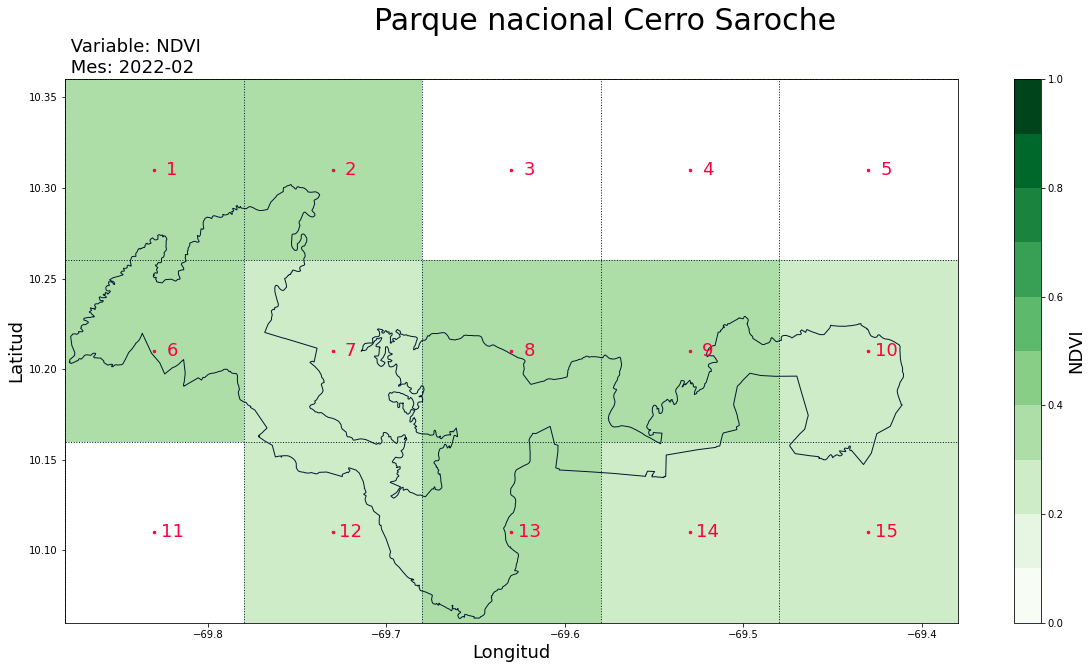

In [31]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np

# centros
x = np.arange(-70.13,-69.13,0.1)
y = np.arange(9.81,10.51,0.1)

# grilla
x_grid = x + 0.05
y_grid  = y + 0.05

# plot
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1)

# raster
time_lebel = 107
levels=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
graf = rds_ndvi.isel(time=time_lebel).ndvi_media.plot(cmap='Greens',
                                                      levels=levels
                                                      )
graf.colorbar.set_label('NDVI',fontsize=18)
ax.add_collection(graf)

# poligonos
x1,y1 = park_poligono.geometry.iloc[0].exterior.xy
ax.plot(x1,y1, color='#001B32', linewidth=1)

x2,y2 = parque_rectangulo.geometry.iloc[0].exterior.xy
ax.plot(x2,y2, color='#BF6300', linewidth=1,linestyle='dashed')


# centroides
annotate = 1
annotate_list = 15*[0]+[11,6,1]+3*[0]+[12,7,2]+3*[0]+[13,8,3]+3*[0]+[14,9,4]+3*[0]+[15,10,5]+30*[0]
for i in list(range(1, len(x) )):
  for j in list(range(1, len(y) )):
    ax.plot(x[i],y[j],color = '#FF003E', marker='.', label=i, markersize=5)
    ax.annotate(str(annotate_list[annotate]),  xy=(x[i]+0.01,y[j]), color='#FF003E',
        fontsize=18, #weight='',
        horizontalalignment='center',
        verticalalignment='center')
    annotate+=1

# grilla
color_grid = '#001B32'
for i in list(range( len(x_grid) )):
  ax.vlines(x = x_grid[i],ymin=min(y_grid),ymax=max(y_grid),
            colors = color_grid,
            linestyles='dotted',
            linewidth=1,
            label = 'vline_multiple - full height')

for i in list(range( len(y_grid) )):
  ax.hlines(y = y_grid[i],xmin=min(x_grid),xmax=max(x_grid),
            colors = color_grid,
            linestyles='dotted',
            linewidth=1,
            label = 'vline_multiple - full height')

# dia
date_srt = datetime.fromordinal(rds_ndvi.time.values[time_lebel]).strftime('%Y-%m')

# titulos
plt.title(f" Variable: NDVI\n Mes: {date_srt}",fontsize=18,loc='left')
plt.title(f"",fontsize=30,loc='center')
plt.suptitle(f"Parque nacional Cerro Saroche\n",fontsize=30)
plt.xlabel("Longitud",loc='center',fontsize=18)
plt.ylabel("Latitud",loc='center',fontsize=18)
plt.xlim([-69.88, -69.38])
plt.ylim([10.06, 10.36])

plt.savefig('./cerro_saroche/figuras/regrillado_ndvi_mes.png')

plt.show()